In [1]:
# 1) Canonicalization & features
import sympy as sp
from sympy import Eq, symbols, Function, diff
import networkx as nx

t,x = symbols('t x', real=True)
u   = Function('u')(x,t)
nu  = sp.symbols('nu', positive=True)   # viscosity

# Burgers and Heat (toy exemplars)
eq_burgers = Eq(diff(u,t) + u*diff(u,x), nu*diff(u, x, 2))
eq_heat    = Eq(diff(u,t),               nu*diff(u, x, 2))

def feature_signature(eq):
    # very rough sketch: refine with real invariants
    expr = sp.simplify(eq.lhs - eq.rhs)
    order_t = max([sum(1 for a in term.atoms(sp.Derivative) if t in a.variables) for term in sp.Add.make_args(expr)])
    order_x = max([sum(1 for a in term.atoms(sp.Derivative) if x in a.variables) for term in sp.Add.make_args(expr)])
    linear  = int(sp.Poly(expr, u).is_linear if expr.has(u) else 1)
    return {'order_t':order_t, 'order_x':order_x, 'linear':linear}

f_b = feature_signature(eq_burgers)
f_h = feature_signature(eq_heat)

# 2) Simple multi-lens score (placeholder; swap in real checks)
def symbolic_similarity(a,b):
    return 1.0 if sp.simplify((a.lhs-a.rhs)-(b.lhs-b.rhs)) == 0 else 0.3  # toy

def pde_proximity(f1,f2):
    same_order = (f1['order_t']==f2['order_t']) + (f1['order_x']==f2['order_x'])
    linearity  = (f1['linear']==f2['linear'])
    return 0.2*same_order + 0.6*linearity

w = 0.5*symbolic_similarity(eq_burgers, eq_heat) + 0.5*pde_proximity(f_b,f_h)

# 3) Graph
G = nx.Graph()
G.add_node("Burgers", kind="Equation", features=f_b, latex=str(sp.latex(eq_burgers)))
G.add_node("Heat",    kind="Equation", features=f_h, latex=str(sp.latex(eq_heat)))
G.add_edge("Burgers", "Heat", type="limit_of", weight=float(w),
           evidence="Hopf–Cole transform → Heat", provenance="CNT seed")

# Export to JSON for 3d-force-graph
import json
data = {
  "nodes":[{"id":n, **G.nodes[n]} for n in G.nodes()],
  "links":[{"source":u,"target":v, **d} for u,v,d in G.edges(data=True)]
}
with open("fieldnet_seed.json","w") as f: json.dump(data,f,indent=2)
"OK: fieldnet_seed.json"


PolynomialError: Derivative(u(x, t), x) contains an element of the set of generators.

In [2]:
import sympy as sp
from sympy import Eq, symbols, Function, Derivative, Add

# === setup (same as before) ===
t, x = symbols('t x', real=True)
u = Function('u')(x, t)
nu = sp.symbols('nu', positive=True)

eq_burgers = sp.Eq(sp.diff(u, t) + u*sp.diff(u, x), nu*sp.diff(u, x, 2))
eq_heat    = sp.Eq(sp.diff(u, t),                   nu*sp.diff(u, x, 2))

def _max_order_in(var, expr):
    """Max total order of differentiation w.r.t. `var` among all derivatives of u in expr."""
    maxo = 0
    for d in expr.atoms(Derivative):
        if u in d.expr.free_symbols or d.expr == u:
            # Count multiplicity of var in this derivative
            o = sum(1 for v,p in d.variable_count if v == var)
            maxo = max(maxo, o)
    return maxo

def _is_linear_in_u_and_derivs(expr):
    """
    Replace u and all its derivatives with fresh symbols and check that expr
    is at most degree 1 in those placeholders.
    """
    # collect all u-derivatives (including u itself)
    atoms = set()
    # u itself
    atoms.add(u)
    # derivatives of u
    atoms |= {d for d in expr.atoms(Derivative) if (d.expr == u)}
    # build placeholders
    repl = {}
    gens = []
    for i, a in enumerate(sorted(atoms, key=lambda z: str(z))):
        s = sp.Symbol(f'U{i}', real=True)
        repl[a] = s
        gens.append(s)
    if not gens:
        return True  # no dependence on u ⇒ linear trivially
    expr_sub = sp.simplify(expr.xreplace(repl))
    # Try to treat as polynomial in placeholders (may still fail if transcendental)
    try:
        P = sp.Poly(expr_sub, *gens, domain='EX')
        return max(sum(mon) for mon in P.monoms()) <= 1
    except Exception:
        # Fall back: heuristic linearity test —
        # check that second partials w.r.t. each placeholder vanish and
        # no products of distinct placeholders appear.
        # Second partials:
        for g in gens:
            if sp.simplify(sp.diff(expr_sub, g, g)) != 0:
                return False
        # Cross terms:
        for i in range(len(gens)):
            for j in range(i+1, len(gens)):
                if sp.simplify(sp.diff(expr_sub, gens[i], gens[j])) != 0:
                    return False
        return True

def feature_signature(eq):
    """
    Compute simple PDE features without using Poly on derivative objects.
    - order_t/order_x: max derivative order wrt t/x on u
    - linear: 1 if linear in u and its derivatives, else 0
    """
    expr = sp.simplify(eq.lhs - eq.rhs)
    # Break into additive terms robustly
    terms = Add.make_args(expr)
    order_t = 0
    order_x = 0
    for term in terms:
        order_t = max(order_t, _max_order_in(t, term))
        order_x = max(order_x, _max_order_in(x, term))
    linear = int(_is_linear_in_u_and_derivs(expr))
    return {'order_t': order_t, 'order_x': order_x, 'linear': linear}

# === try it ===
f_b = feature_signature(eq_burgers)
f_h = feature_signature(eq_heat)
f_b, f_h


({'order_t': 1, 'order_x': 1, 'linear': 0},
 {'order_t': 1, 'order_x': 1, 'linear': 1})

C:\Users\caleb\AppData\Local\Temp\ipykernel_20680\1642291054.py:86: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ART = ROOT / 'artifacts' / 'neon_deck' / dt.datetime.utcnow().strftime('%Y%m%d-%H%M%SZ')
C:\Users\caleb\AppData\Local\Temp\ipykernel_20680\1642291054.py:91: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'ts_utc': dt.datetime.utcnow().isoformat() + 'Z',


C:\Users\caleb\AppData\Local\Temp\ipykernel_20680\1642291054.py:354: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = FuncAnimation(fig, animate, interval=50, blit=False)


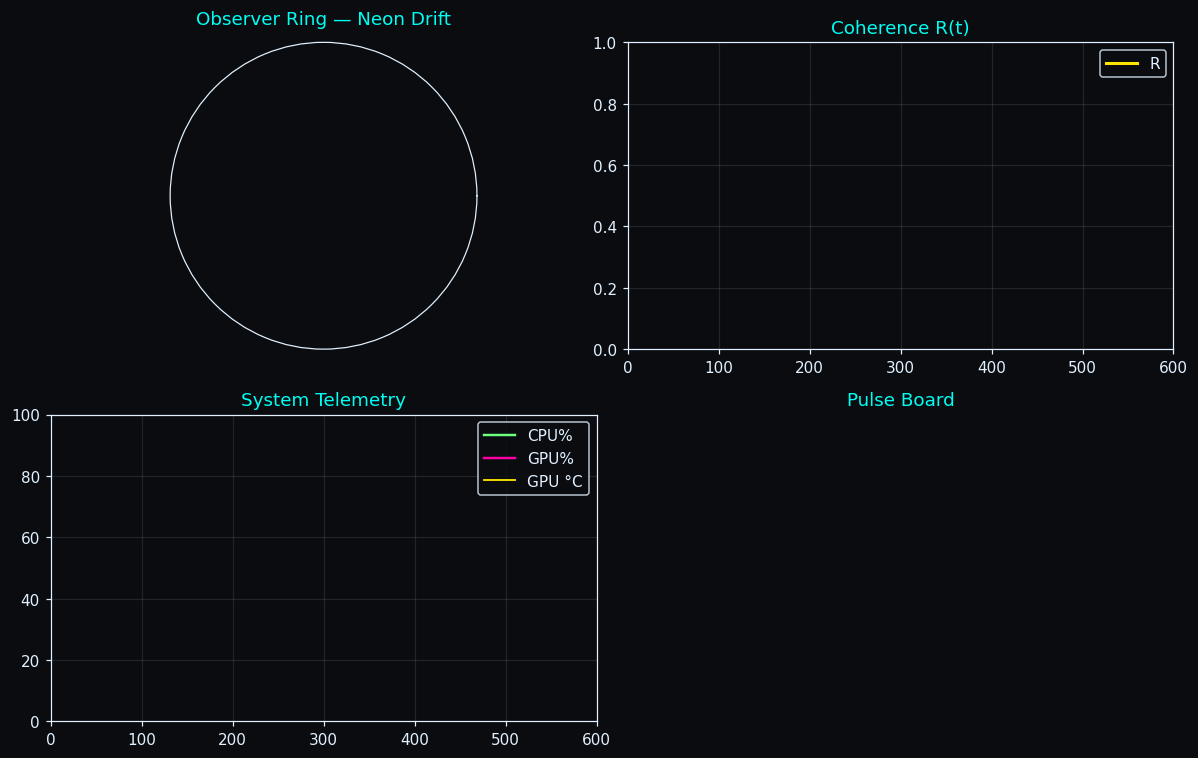

CNT Neon Cyberdeck is loaded. Press 'Start' to run the drift.
Artifacts directory: E:\CNT\artifacts\neon_deck\20251106-050905Z


In [3]:
# CNT Neon Cyberdeck — v0.1
# -------------------------------------------------------------
# A cyberpunk, neon‑glow control room in a single Jupyter cell:
# • Live Kuramoto drift simulation (Observer Ring + order parameter R)
# • GPU/CPU telemetry (pynvml + psutil, graceful fallbacks)
# • Glyph Pulse detection on R-threshold crossings with log artifacts
# • Neon UI via matplotlib + ipywidgets controls (Start/Stop/Reset/Save)
# • Saves run metadata + pulse log under CNT_LAB_DIR or ./artifacts
# -------------------------------------------------------------
# Quick start:
#   1) Paste this cell into a fresh Jupyter notebook and run it.
#   2) Use the controls under the plots. Tweak K (coupling) and Noise.
#   3) Watch the neon Observer Ring cohere and fire pulses when R rises.
#   4) Click "Save Snapshot" to export a PNG; logs write automatically.
#
# Dependencies (install if needed):
#   pip install psutil pynvml ipywidgets matplotlib numpy
#   (optional) pip install cupy-cuda12x   # if you want GPU for the sim
#
# Notes:
# - The Kuramoto evolution uses the mean-field reduction (O(N)) so it's fast.
# - If CuPy is available, simulation math runs on GPU; plotting uses NumPy.
# - If pynvml is unavailable, GPU telemetry is skipped gracefully.
# - Artifacts land in: {CNT_LAB_DIR or CWD}/artifacts/neon_deck/<timestamp>

from __future__ import annotations
import os, json, time, math, threading, datetime as dt
from pathlib import Path

# --- Robust imports with graceful fallbacks ---
try:
    import cupy as cp
    HAS_CUPY = True
except Exception:
    cp = None
    HAS_CUPY = False

import numpy as np

try:
    import psutil
    HAS_PSUTIL = True
except Exception:
    HAS_PSUTIL = False

try:
    import pynvml
    pynvml.nvmlInit()
    _NV_DEV = pynvml.nvmlDeviceGetHandleByIndex(0)
    HAS_NVML = True
except Exception:
    HAS_NVML = False

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

try:
    import ipywidgets as W
    from IPython.display import display, HTML, clear_output
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False

# --- Neon theme helpers ---
NEON_BG = '#0a0c10'       # near-black
NEON_FG = '#e2f1ff'       # pale cyan-white
NEON_CYAN = '#00fff2'
NEON_MAGENTA = '#ff00a7'
NEON_YELLOW = '#ffe600'
NEON_GREEN = '#6dff80'

plt.rcParams.update({
    'figure.facecolor': NEON_BG,
    'axes.facecolor': NEON_BG,
    'axes.edgecolor': NEON_FG,
    'axes.labelcolor': NEON_FG,
    'xtick.color': NEON_FG,
    'ytick.color': NEON_FG,
    'text.color': NEON_FG,
    'figure.dpi': 110,
})

# --- Artifact paths ---
ROOT = Path(os.environ.get('CNT_LAB_DIR', os.getcwd()))
ART = ROOT / 'artifacts' / 'neon_deck' / dt.datetime.utcnow().strftime('%Y%m%d-%H%M%SZ')
ART.mkdir(parents=True, exist_ok=True)

RUN_META = {
    'run_id': ART.name,
    'ts_utc': dt.datetime.utcnow().isoformat() + 'Z',
    'env': {
        'CNT_LAB_DIR': os.environ.get('CNT_LAB_DIR', None),
        'HAS_CUPY': HAS_CUPY,
        'HAS_NVML': HAS_NVML,
        'HAS_PSUTIL': HAS_PSUTIL,
    }
}
(ART / 'run_meta.json').write_text(json.dumps(RUN_META, indent=2))

# --- Kuramoto mean-field simulator (O(N)) ---
class KuramotoDeck:
    def __init__(self, N=256, dt=0.03, K=1.2, noise=0.04, seed=1, use_gpu=True):
        self.N = int(N)
        self.dt = float(dt)
        self.K = float(K)
        self.noise = float(noise)
        self.rng = np.random.default_rng(seed)
        self.use_gpu = bool(use_gpu and HAS_CUPY)
        self._xp = cp if self.use_gpu else np
        # State
        self.theta = self._xp.asarray(self.rng.uniform(0, 2*math.pi, size=self.N))
        self.omega = self._xp.asarray(self.rng.normal(0.0, 1.0, size=self.N))
        self.t = 0.0
        self.R_hist = []  # order parameter over time (float, on CPU)
        self.max_hist = 2000
        # Pulse detection
        self.phi_on = 0.65
        self.phi_off = 0.55
        self._armed = True
        self.pulses = []   # list of {'t':..., 'R':..., 'psi':...}
        # Thread control
        self.running = False
        self._lock = threading.Lock()

    def _to_cpu(self, x):
        if self.use_gpu:
            return cp.asnumpy(x)
        return x

    def step(self, steps=1):
        xp = self._xp
        for _ in range(steps):
            # Mean field (order parameter)
            z = xp.mean(xp.exp(1j * self.theta))  # complex
            r = xp.abs(z)
            psi = xp.angle(z)
            # Kuramoto mean-field update
            dtheta = self.omega + self.K * r * xp.sin(psi - self.theta)
            if self.noise > 0:
                dtheta += xp.sqrt(self.noise) * xp.sqrt(self.dt) * xp.asarray(self.rng.standard_normal(self.N))
            self.theta = (self.theta + self.dt * dtheta) % (2*math.pi)
            self.t += self.dt
            # Pulse detection (one-shot on crossing)
            r_cpu = float(self._to_cpu(r))
            self.R_hist.append(r_cpu)
            if len(self.R_hist) > self.max_hist:
                self.R_hist = self.R_hist[-self.max_hist:]
            if self._armed and r_cpu >= self.phi_on:
                psi_cpu = float(self._to_cpu(psi))
                self.pulses.append({'t': self.t, 'R': r_cpu, 'psi': psi_cpu})
                self._armed = False
            elif (not self._armed) and r_cpu <= self.phi_off:
                self._armed = True

    def reset(self):
        with self._lock:
            xp = self._xp
            self.theta = xp.asarray(self.rng.uniform(0, 2*math.pi, size=self.N))
            self.omega = xp.asarray(self.rng.normal(0.0, 1.0, size=self.N))
            self.t = 0.0
            self.R_hist.clear()
            self.pulses.clear()
            self._armed = True

    # Telemetry helpers
    def cpu_util(self):
        if not HAS_PSUTIL:
            return None
        try:
            return psutil.cpu_percent(interval=None)
        except Exception:
            return None

    def gpu_util_temp(self):
        if not HAS_NVML:
            return None, None
        try:
            u = pynvml.nvmlDeviceGetUtilizationRates(_NV_DEV)
            temp = pynvml.nvmlDeviceGetTemperature(_NV_DEV, pynvml.NVML_TEMPERATURE_GPU)
            return float(u.gpu), float(temp)
        except Exception:
            return None, None

# --- Build UI + Animation ---

deck = KuramotoDeck(N=256, dt=0.03, K=1.2, noise=0.04, seed=7, use_gpu=True)

# Telemetry buffers
HIST = 600
cpu_hist = []
gpu_hist = []
tmp_hist = []
R_line = None
CPU_line = None
GPU_line = None
TMP_line = None

# Figure layout
fig = plt.figure(figsize=(11, 7))
ax0 = plt.subplot2grid((2,2), (0,0), projection='polar')
ax1 = plt.subplot2grid((2,2), (0,1))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (1,1))

# Ax0: Observer Ring (polar phases)
ax0.set_facecolor(NEON_BG)
ax0.set_title('Observer Ring — Neon Drift', color=NEON_CYAN, pad=12)
ax0.set_rticks([])
ax0.set_thetagrids([])
scat = ax0.scatter([], [], s=8, c=NEON_CYAN, alpha=0.75)
arrow, = ax0.plot([], [], lw=2.5, color=NEON_MAGENTA)

# Ax1: R(t) order parameter time‑series
ax1.set_title('Coherence R(t)', color=NEON_CYAN)
ax1.set_ylim(0, 1.0)
ax1.set_xlim(0, HIST)
ax1.grid(alpha=0.15)
R_line, = ax1.plot([], [], lw=2.0, color=NEON_YELLOW, label='R')
ax1.legend(facecolor=NEON_BG, edgecolor=NEON_FG)

# Ax2: CPU/GPU telemetry
ax2.set_title('System Telemetry', color=NEON_CYAN)
ax2.set_ylim(0, 100)
ax2.set_xlim(0, HIST)
ax2.grid(alpha=0.15)
CPU_line, = ax2.plot([], [], lw=1.6, color=NEON_GREEN, label='CPU%')
GPU_line, = ax2.plot([], [], lw=1.6, color=NEON_MAGENTA, label='GPU%')
TMP_line, = ax2.plot([], [], lw=1.2, color=NEON_YELLOW, label='GPU °C')
ax2.legend(facecolor=NEON_BG, edgecolor=NEON_FG)

# Ax3: Status + Pulse board
ax3.set_title('Pulse Board', color=NEON_CYAN)
ax3.set_axis_off()
status_txt = ax3.text(0.02, 0.98, '', va='top', ha='left', fontsize=10, color=NEON_FG, family='monospace')

# Neon header (HTML)
if HAS_WIDGETS:
    display(HTML(f"""
    <div style='font-family:Consolas,monospace;background:{NEON_BG};padding:10px 12px;border:1px solid {NEON_CYAN};box-shadow:0 0 12px {NEON_CYAN};border-radius:8px;margin-bottom:8px;'>
      <div style='font-size:18px;color:{NEON_CYAN};letter-spacing:0.8px;'>CNT Neon Cyberdeck — <span style='color:{NEON_MAGENTA}'>Observer Ring</span></div>
      <div style='color:{NEON_FG};opacity:0.85;'>Run ID: <b style='color:{NEON_YELLOW}'>{RUN_META['run_id']}</b> &nbsp;•&nbsp; GPU:{'ON' if deck.use_gpu else 'OFF'} | NVML:{'ON' if HAS_NVML else 'OFF'} | PSUTIL:{'ON' if HAS_PSUTIL else 'OFF'}</div>
    </div>
    """))

# Controls
if HAS_WIDGETS:
    slider_K = W.FloatSlider(value=deck.K, min=0.0, max=4.0, step=0.01, description='K', readout=True, continuous_update=True)
    slider_noise = W.FloatSlider(value=deck.noise, min=0.0, max=0.2, step=0.005, description='Noise', readout=True, continuous_update=True)
    btn_start = W.Button(description='Start', button_style='success')
    btn_stop = W.Button(description='Stop', button_style='warning')
    btn_reset = W.Button(description='Reset', button_style='')
    btn_snap = W.Button(description='Save Snapshot', button_style='info')

    def on_start(_):
        deck.running = True
    def on_stop(_):
        deck.running = False
        # Persist logs on pause
        (ART / 'pulses.json').write_text(json.dumps(deck.pulses, indent=2))
    def on_reset(_):
        deck.reset()
        cpu_hist.clear(); gpu_hist.clear(); tmp_hist.clear()
        ax1.set_xlim(0, HIST); ax2.set_xlim(0, HIST)
        fig.canvas.draw_idle()
    def on_snap(_):
        png = ART / f'snapshot_{int(time.time())}.png'
        fig.savefig(png, bbox_inches='tight', facecolor=NEON_BG)
        print(f"Saved → {png}")

    btn_start.on_click(on_start)
    btn_stop.on_click(on_stop)
    btn_reset.on_click(on_reset)
    btn_snap.on_click(on_snap)

    display(W.HBox([slider_K, slider_noise]))
    display(W.HBox([btn_start, btn_stop, btn_reset, btn_snap]))

# Animation update
frame_idx = 0

def animate(_):
    global frame_idx
    # Update parameters from widgets
    if HAS_WIDGETS:
        deck.K = float(slider_K.value)
        deck.noise = float(slider_noise.value)
    # Step simulation if running
    if deck.running:
        deck.step(steps=1)
    # Phases for polar scatter
    th = deck.theta
    if deck.use_gpu:
        th = cp.asnumpy(th)
    rr = np.ones_like(th)
    scat.set_offsets(np.c_[th, rr])
    # Arrow for mean phase psi with length r
    if len(deck.R_hist):
        R_now = deck.R_hist[-1]
    else:
        R_now = 0.0
    # Compute psi for arrow from current z
    z = np.mean(np.exp(1j * (th)))
    psi = float(np.angle(z))
    arrow_th = np.linspace(psi, psi, 2)
    arrow_r = np.linspace(0.0, min(1.0, R_now*1.1), 2)
    narrow.set_data(arrow_th, arrow_r)

    # R(t) time series
    xR = np.arange(len(deck.R_hist))
    R_line.set_data(xR[-HIST:], np.array(deck.R_hist[-HIST:]))
    ax1.set_xlim(max(0, len(deck.R_hist)-HIST), max(HIST, len(deck.R_hist)))

    # Telemetry
    cpu = deck.cpu_util()
    gpu, tmp = deck.gpu_util_temp()
    if cpu is not None:
        cpu_hist.append(cpu)
    if gpu is not None:
        gpu_hist.append(gpu)
    if tmp is not None:
        tmp_hist.append(tmp)

    # Clamp hist length
    for buf in (cpu_hist, gpu_hist, tmp_hist):
        if len(buf) > HIST:
            del buf[:len(buf)-HIST]

    xT = np.arange(len(cpu_hist))
    if len(cpu_hist):
        CPU_line.set_data(xT, np.array(cpu_hist))
    if len(gpu_hist):
        GPU_line.set_data(np.arange(len(gpu_hist)), np.array(gpu_hist))
    if len(tmp_hist):
        TMP_line.set_data(np.arange(len(tmp_hist)), np.array(tmp_hist))
    ax2.set_xlim(max(0, len(cpu_hist)-HIST), max(HIST, len(cpu_hist)))

    # Status board
    pulses_n = len(deck.pulses)
    armed = deck._armed
    status = [
        f"t = {deck.t:7.2f} s",
        f"R = {R_now:5.3f} | pulses = {pulses_n}",
        f"K = {deck.K:.3f} | noise = {deck.noise:.3f}",
        f"CPU%: {cpu if cpu is not None else '—'}  |  GPU%: {gpu if gpu is not None else '—'}  |  Temp: {tmp if tmp is not None else '—'}°C",
        f"Armed: {'YES' if armed else 'NO '}  (φ_on={deck.phi_on:.2f}, φ_off={deck.phi_off:.2f})",
        f"Run: {RUN_META['run_id']}  •  Artifacts: {ART}"
    ]
    status_txt.set_text("\n".join(status))

    frame_idx += 1
    return scat, narrow, R_line, CPU_line, GPU_line, TMP_line, status_txt

anim = FuncAnimation(fig, animate, interval=50, blit=False)
plt.tight_layout()
plt.show()

# Auto-start in paused mode; user can press Start.
print("CNT Neon Cyberdeck is loaded. Press 'Start' to run the drift.")
print(f"Artifacts directory: {ART}")


In [4]:
# In a fresh Jupyter cell
!pip install -q nvidia-ml-py3 psutil
import pynvml as nv
nv.nvmlInit()
print("NVML OK →", nv.nvmlSystemGetDriverVersion().decode())


NVMLError_LibraryNotFound: NVML Shared Library Not Found

C:\Users\caleb\CNT_Lab\.venv\Lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


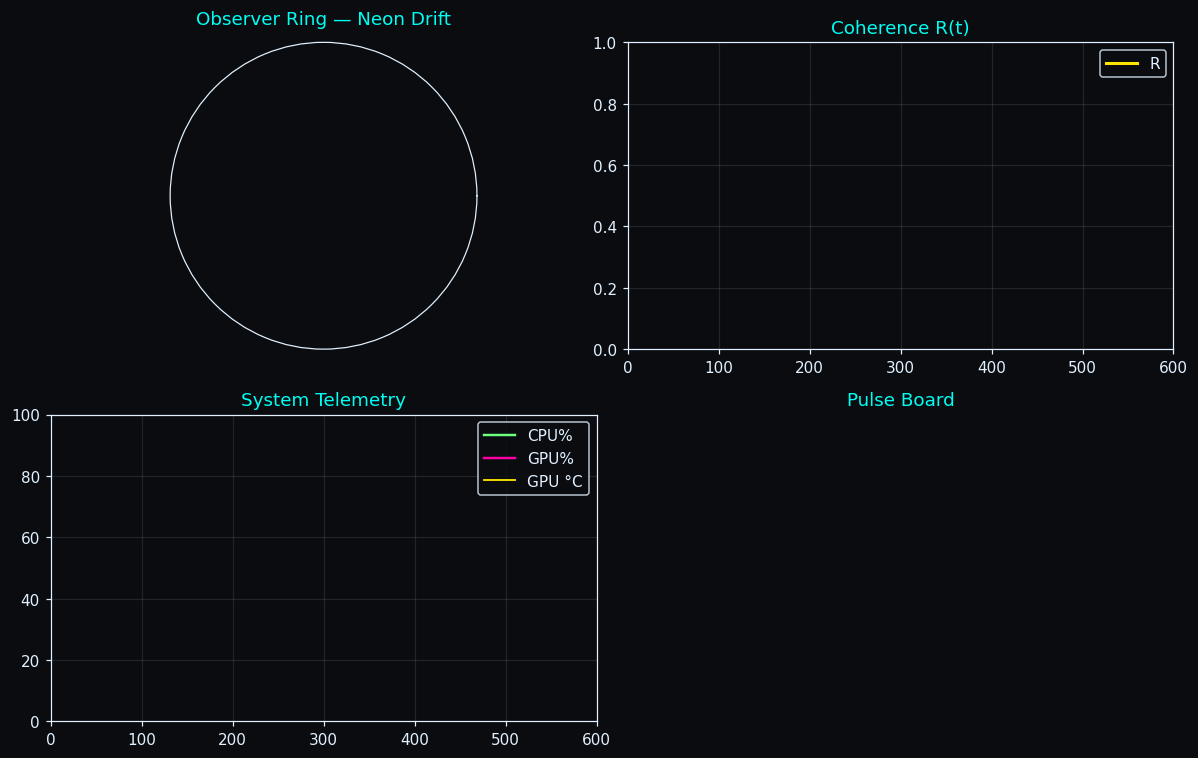

CNT Neon Cyberdeck is loaded. Press 'Start' to run the drift.
Artifacts directory: E:\CNT\artifacts\neon_deck\20251106-051934Z


In [5]:
# CNT Neon Cyberdeck — v0.1
# -------------------------------------------------------------
# A cyberpunk, neon‑glow control room in a single Jupyter cell:
# • Live Kuramoto drift simulation (Observer Ring + order parameter R)
# • GPU/CPU telemetry (pynvml + psutil, graceful fallbacks)
# • Glyph Pulse detection on R-threshold crossings with log artifacts
# • Neon UI via matplotlib + ipywidgets controls (Start/Stop/Reset/Save)
# • Saves run metadata + pulse log under CNT_LAB_DIR or ./artifacts
# -------------------------------------------------------------
# Quick start:
#   1) Paste this cell into a fresh Jupyter notebook and run it.
#   2) Use the controls under the plots. Tweak K (coupling) and Noise.
#   3) Watch the neon Observer Ring cohere and fire pulses when R rises.
#   4) Click "Save Snapshot" to export a PNG; logs write automatically.
#
# Dependencies (install if needed):
#   pip install psutil pynvml ipywidgets matplotlib numpy
#   (optional) pip install cupy-cuda12x   # if you want GPU for the sim
#
# Notes:
# - The Kuramoto evolution uses the mean-field reduction (O(N)) so it's fast.
# - If CuPy is available, simulation math runs on GPU; plotting uses NumPy.
# - If pynvml is unavailable, GPU telemetry is skipped gracefully.
# - Artifacts land in: {CNT_LAB_DIR or CWD}/artifacts/neon_deck/<timestamp>

from __future__ import annotations
import os, json, time, math, threading, datetime as dt
from pathlib import Path

# --- Robust imports with graceful fallbacks ---
try:
    import cupy as cp
    HAS_CUPY = True
except Exception:
    cp = None
    HAS_CUPY = False

import numpy as np

try:
    import psutil
    HAS_PSUTIL = True
except Exception:
    HAS_PSUTIL = False

try:
    import pynvml
    pynvml.nvmlInit()
    _NV_DEV = pynvml.nvmlDeviceGetHandleByIndex(0)
    HAS_NVML = True
except Exception:
    HAS_NVML = False

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

try:
    import ipywidgets as W
    from IPython.display import display, HTML, clear_output
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False

# --- Neon theme helpers ---
NEON_BG = '#0a0c10'       # near-black
NEON_FG = '#e2f1ff'       # pale cyan-white
NEON_CYAN = '#00fff2'
NEON_MAGENTA = '#ff00a7'
NEON_YELLOW = '#ffe600'
NEON_GREEN = '#6dff80'

plt.rcParams.update({
    'figure.facecolor': NEON_BG,
    'axes.facecolor': NEON_BG,
    'axes.edgecolor': NEON_FG,
    'axes.labelcolor': NEON_FG,
    'xtick.color': NEON_FG,
    'ytick.color': NEON_FG,
    'text.color': NEON_FG,
    'figure.dpi': 110,
})

# --- Artifact paths ---
ROOT = Path(os.environ.get('CNT_LAB_DIR', os.getcwd()))
ART = ROOT / 'artifacts' / 'neon_deck' / dt.datetime.now(dt.timezone.utc).strftime('%Y%m%d-%H%M%SZ')
ART.mkdir(parents=True, exist_ok=True)

RUN_META = {
    'run_id': ART.name,
    'ts_utc': dt.datetime.now(dt.timezone.utc).isoformat() + 'Z',
    'env': {
        'CNT_LAB_DIR': os.environ.get('CNT_LAB_DIR', None),
        'HAS_CUPY': HAS_CUPY,
        'HAS_NVML': HAS_NVML,
        'HAS_PSUTIL': HAS_PSUTIL,
    }
}
(ART / 'run_meta.json').write_text(json.dumps(RUN_META, indent=2))

# --- Kuramoto mean-field simulator (O(N)) ---
class KuramotoDeck:
    def __init__(self, N=256, dt=0.03, K=1.2, noise=0.04, seed=1, use_gpu=True):
        self.N = int(N)
        self.dt = float(dt)
        self.K = float(K)
        self.noise = float(noise)
        self.rng = np.random.default_rng(seed)
        self.use_gpu = bool(use_gpu and HAS_CUPY)
        self._xp = cp if self.use_gpu else np
        # State
        self.theta = self._xp.asarray(self.rng.uniform(0, 2*math.pi, size=self.N))
        self.omega = self._xp.asarray(self.rng.normal(0.0, 1.0, size=self.N))
        self.t = 0.0
        self.R_hist = []  # order parameter over time (float, on CPU)
        self.max_hist = 2000
        # Pulse detection
        self.phi_on = 0.65
        self.phi_off = 0.55
        self._armed = True
        self.pulses = []   # list of {'t':..., 'R':..., 'psi':...}
        # Thread control
        self.running = False
        self._lock = threading.Lock()

    def _to_cpu(self, x):
        if self.use_gpu:
            return cp.asnumpy(x)
        return x

    def step(self, steps=1):
        xp = self._xp
        for _ in range(steps):
            # Mean field (order parameter)
            z = xp.mean(xp.exp(1j * self.theta))  # complex
            r = xp.abs(z)
            psi = xp.angle(z)
            # Kuramoto mean-field update
            dtheta = self.omega + self.K * r * xp.sin(psi - self.theta)
            if self.noise > 0:
                dtheta += xp.sqrt(self.noise) * xp.sqrt(self.dt) * xp.asarray(self.rng.standard_normal(self.N))
            self.theta = (self.theta + self.dt * dtheta) % (2*math.pi)
            self.t += self.dt
            # Pulse detection (one-shot on crossing)
            r_cpu = float(self._to_cpu(r))
            self.R_hist.append(r_cpu)
            if len(self.R_hist) > self.max_hist:
                self.R_hist = self.R_hist[-self.max_hist:]
            if self._armed and r_cpu >= self.phi_on:
                psi_cpu = float(self._to_cpu(psi))
                self.pulses.append({'t': self.t, 'R': r_cpu, 'psi': psi_cpu})
                self._armed = False
            elif (not self._armed) and r_cpu <= self.phi_off:
                self._armed = True

    def reset(self):
        with self._lock:
            xp = self._xp
            self.theta = xp.asarray(self.rng.uniform(0, 2*math.pi, size=self.N))
            self.omega = xp.asarray(self.rng.normal(0.0, 1.0, size=self.N))
            self.t = 0.0
            self.R_hist.clear()
            self.pulses.clear()
            self._armed = True

    # Telemetry helpers
    def cpu_util(self):
        if not HAS_PSUTIL:
            return None
        try:
            return psutil.cpu_percent(interval=None)
        except Exception:
            return None

    def gpu_util_temp(self):
        if not HAS_NVML:
            return None, None
        try:
            u = pynvml.nvmlDeviceGetUtilizationRates(_NV_DEV)
            temp = pynvml.nvmlDeviceGetTemperature(_NV_DEV, pynvml.NVML_TEMPERATURE_GPU)
            return float(u.gpu), float(temp)
        except Exception:
            return None, None

# --- Build UI + Animation ---

deck = KuramotoDeck(N=256, dt=0.03, K=1.2, noise=0.04, seed=7, use_gpu=True)

# Telemetry buffers
HIST = 600
cpu_hist = []
gpu_hist = []
tmp_hist = []
R_line = None
CPU_line = None
GPU_line = None
TMP_line = None

# Figure layout
fig = plt.figure(figsize=(11, 7))
ax0 = plt.subplot2grid((2,2), (0,0), projection='polar')
ax1 = plt.subplot2grid((2,2), (0,1))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (1,1))

# Ax0: Observer Ring (polar phases)
ax0.set_facecolor(NEON_BG)
ax0.set_title('Observer Ring — Neon Drift', color=NEON_CYAN, pad=12)
ax0.set_rticks([])
ax0.set_thetagrids([])
ax0.set_rlim(0, 1.02)
scat = ax0.scatter([], [], s=8, c=NEON_CYAN, alpha=0.75)
arrow, = ax0.plot([], [], lw=2.5, color=NEON_MAGENTA)

# Ax1: R(t) order parameter time‑series
ax1.set_title('Coherence R(t)', color=NEON_CYAN)
ax1.set_ylim(0, 1.0)
ax1.set_xlim(0, HIST)
ax1.grid(alpha=0.15)
R_line, = ax1.plot([], [], lw=2.0, color=NEON_YELLOW, label='R')
ax1.legend(facecolor=NEON_BG, edgecolor=NEON_FG)

# Ax2: CPU/GPU telemetry
ax2.set_title('System Telemetry', color=NEON_CYAN)
ax2.set_ylim(0, 100)
ax2.set_xlim(0, HIST)
ax2.grid(alpha=0.15)
CPU_line, = ax2.plot([], [], lw=1.6, color=NEON_GREEN, label='CPU%')
GPU_line, = ax2.plot([], [], lw=1.6, color=NEON_MAGENTA, label='GPU%')
TMP_line, = ax2.plot([], [], lw=1.2, color=NEON_YELLOW, label='GPU °C')
ax2.legend(facecolor=NEON_BG, edgecolor=NEON_FG)

# Ax3: Status + Pulse board
ax3.set_title('Pulse Board', color=NEON_CYAN)
ax3.set_axis_off()
status_txt = ax3.text(0.02, 0.98, '', va='top', ha='left', fontsize=10, color=NEON_FG, family='monospace')

# Neon header (HTML)
if HAS_WIDGETS:
    display(HTML(f"""
    <div style='font-family:Consolas,monospace;background:{NEON_BG};padding:10px 12px;border:1px solid {NEON_CYAN};box-shadow:0 0 12px {NEON_CYAN};border-radius:8px;margin-bottom:8px;'>
      <div style='font-size:18px;color:{NEON_CYAN};letter-spacing:0.8px;'>CNT Neon Cyberdeck — <span style='color:{NEON_MAGENTA}'>Observer Ring</span></div>
      <div style='color:{NEON_FG};opacity:0.85;'>Run ID: <b style='color:{NEON_YELLOW}'>{RUN_META['run_id']}</b> &nbsp;•&nbsp; GPU:{'ON' if deck.use_gpu else 'OFF'} | NVML:{'ON' if HAS_NVML else 'OFF'} | PSUTIL:{'ON' if HAS_PSUTIL else 'OFF'}</div>
    </div>
    """))

# Controls
if HAS_WIDGETS:
    slider_K = W.FloatSlider(value=deck.K, min=0.0, max=4.0, step=0.01, description='K', readout=True, continuous_update=True)
    slider_noise = W.FloatSlider(value=deck.noise, min=0.0, max=0.2, step=0.005, description='Noise', readout=True, continuous_update=True)
    btn_start = W.Button(description='Start', button_style='success')
    btn_stop = W.Button(description='Stop', button_style='warning')
    btn_reset = W.Button(description='Reset', button_style='')
    btn_snap = W.Button(description='Save Snapshot', button_style='info')

    def on_start(_):
        deck.running = True
    def on_stop(_):
        deck.running = False
        # Persist logs on pause
        (ART / 'pulses.json').write_text(json.dumps(deck.pulses, indent=2))
    def on_reset(_):
        deck.reset()
        cpu_hist.clear(); gpu_hist.clear(); tmp_hist.clear()
        ax1.set_xlim(0, HIST); ax2.set_xlim(0, HIST)
        fig.canvas.draw_idle()
    def on_snap(_):
        png = ART / f'snapshot_{int(time.time())}.png'
        fig.savefig(png, bbox_inches='tight', facecolor=NEON_BG)
        print(f"Saved → {png}")

    btn_start.on_click(on_start)
    btn_stop.on_click(on_stop)
    btn_reset.on_click(on_reset)
    btn_snap.on_click(on_snap)

    display(W.HBox([slider_K, slider_noise]))
    display(W.HBox([btn_start, btn_stop, btn_reset, btn_snap]))

# Animation update
frame_idx = 0

def animate(_):
    global frame_idx
    # Update parameters from widgets
    if HAS_WIDGETS:
        deck.K = float(slider_K.value)
        deck.noise = float(slider_noise.value)
    # Step simulation if running
    if deck.running:
        deck.step(steps=1)
    # Phases for polar scatter
    th = deck.theta
    if deck.use_gpu:
        th = cp.asnumpy(th)
    rr = np.ones_like(th)
    scat.set_offsets(np.c_[th, rr])
    # Arrow for mean phase psi with length r
    if len(deck.R_hist):
        R_now = deck.R_hist[-1]
    else:
        R_now = 0.0
    # Compute psi for arrow from current z
    z = np.mean(np.exp(1j * (th)))
    psi = float(np.angle(z))
    arrow_th = np.linspace(psi, psi, 2)
    arrow_r = np.linspace(0.0, min(1.0, R_now*1.1), 2)
    narrow.set_data(arrow_th, arrow_r)

    # R(t) time series
    xR = np.arange(len(deck.R_hist))
    R_line.set_data(xR[-HIST:], np.array(deck.R_hist[-HIST:]))
    ax1.set_xlim(max(0, len(deck.R_hist)-HIST), max(HIST, len(deck.R_hist)))

    # Telemetry
    cpu = deck.cpu_util()
    gpu, tmp = deck.gpu_util_temp()
    if cpu is not None:
        cpu_hist.append(cpu)
    if gpu is not None:
        gpu_hist.append(gpu)
    if tmp is not None:
        tmp_hist.append(tmp)

    # Clamp hist length
    for buf in (cpu_hist, gpu_hist, tmp_hist):
        if len(buf) > HIST:
            del buf[:len(buf)-HIST]

    xT = np.arange(len(cpu_hist))
    if len(cpu_hist):
        CPU_line.set_data(xT, np.array(cpu_hist))
    if len(gpu_hist):
        GPU_line.set_data(np.arange(len(gpu_hist)), np.array(gpu_hist))
    if len(tmp_hist):
        TMP_line.set_data(np.arange(len(tmp_hist)), np.array(tmp_hist))
    ax2.set_xlim(max(0, len(cpu_hist)-HIST), max(HIST, len(cpu_hist)))

    # Status board
    pulses_n = len(deck.pulses)
    armed = deck._armed
    status = [
        f"t = {deck.t:7.2f} s",
        f"R = {R_now:5.3f} | pulses = {pulses_n}",
        f"K = {deck.K:.3f} | noise = {deck.noise:.3f}",
        f"CPU%: {cpu if cpu is not None else '—'}  |  GPU%: {gpu if gpu is not None else '—'}  |  Temp: {tmp if tmp is not None else '—'}°C",
        f"Armed: {'YES' if armed else 'NO '}  (φ_on={deck.phi_on:.2f}, φ_off={deck.phi_off:.2f})",
        f"Run: {RUN_META['run_id']}  •  Artifacts: {ART}"
    ]
    status_txt.set_text("\n".join(status))

    frame_idx += 1
    return scat, narrow, R_line, CPU_line, GPU_line, TMP_line, status_txt

anim = FuncAnimation(fig, animate, interval=50, blit=False, cache_frame_data=False)
plt.tight_layout()
plt.show()

# Auto-start in paused mode; user can press Start.
print("CNT Neon Cyberdeck is loaded. Press 'Start' to run the drift.")
print(f"Artifacts directory: {ART}")
